In [1]:
from mltrace import Component, clean_db
from mltrace.client import create_labels, retract_labels

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import string
import time

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
# Params

max_num_labels = 50000
step_size = 10000

num_iter = 3

In [8]:
c = Component(
        name="test-ifc-commit",
        owner="shreya",
        description="Measures commit time with varying amount of labels.",
        tags=["nyc-taxicab"],
    )

In [9]:
@c.run(input_vars={"inputs": "labels"}, output_vars=["outputs"])
def run_fake_computation_with_labels(inputs, labels):
    outputs = inputs * 2
    return outputs

In [10]:
@c.run(input_vars=["inputs"], output_vars=["outputs"])
def run_fake_computation_without_labels(inputs):
    outputs = inputs * 2
    return outputs

In [11]:
def create_label(size=10, chars=string.ascii_uppercase):
    return "".join(random.choice(chars) for _ in range(size))

In [17]:
ifc_results = []
without_ifc_results = []

for i in range(num_iter):
    ifc_result = {}
    without_ifc_result = {}
    
    for num_labels in range(1, max_num_labels, step_size):
        print(num_labels)
        inputs = np.random.rand(1000)
        labels = [create_label() for _ in range(num_labels)]

        # time the computation
        start_time = time.time()
        run_fake_computation_with_labels(inputs=inputs, labels=labels)
        end_time = time.time()
        clean_db()

        # Log time
        ifc_result[num_labels] = end_time - start_time

        start_time = time.time()
        run_fake_computation_without_labels(inputs=inputs)
        end_time = time.time()
        without_ifc_result[num_labels] = end_time - start_time
        clean_db()
    
    ifc_results.append(ifc_result)
    without_ifc_results.append(without_ifc_result)


1
10001
20001
30001
40001
1
10001
20001
30001
40001
1
10001
20001
30001
40001


In [31]:
first_copy = first_copy.reset_index()

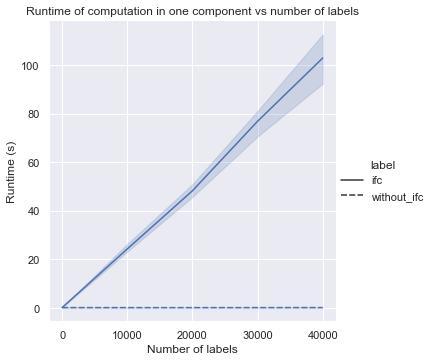

In [32]:
# Make plots

# ifc_df = pd.concat([pd.DataFrame({"num_labels": list(ifc_result.keys()), "time": list(ifc_result.values()), "label": "ifc", "idx": idx}) for idx, ifc_result in enumerate(ifc_results)])

# without_ifc_df = pd.concat([pd.DataFrame({"num_labels": list(without_ifc_result.keys()), "time": list(without_ifc_result.values()), "label": "without_ifc", "idx": idx}) for idx, without_ifc_result in enumerate(without_ifc_results)])

# df = pd.concat([ifc_df, without_ifc_df])

sns.set(style="darkgrid")
sns.relplot(x="num_labels", y="time", style="label", data=first_copy, kind="line")
plt.title("Runtime of computation in one component vs number of labels")
plt.xlabel("Number of labels")
plt.ylabel("Runtime (s)")
plt.show()

## Experiments to assess how runtime changes with number of steps in the pipeline (should be linear)

In [21]:
# Vary number of steps in the pipeline

num_steps_in_pipeline = 10

ifc_results = []
without_ifc_results = []

for i in range(num_iter):
    ifc_result = {}
    without_ifc_result = {}

    for num_steps in range(1, num_steps_in_pipeline):
        print(num_steps)
        inputs = np.random.rand(1000)
        labels = [create_label() for _ in range(step_size)]

        # time the computation
        start_time = time.time()
        for _ in range(num_steps):
            inputs = run_fake_computation_with_labels(inputs=inputs, labels=labels)
        end_time = time.time()
        clean_db()

        # Log time
        ifc_result[num_steps] = end_time - start_time

        start_time = time.time()
        for _ in range(num_steps):
            inputs = run_fake_computation_without_labels(inputs=inputs)
        end_time = time.time()
        without_ifc_result[num_steps] = end_time - start_time
        clean_db()
    
    ifc_results.append(ifc_result)
    without_ifc_results.append(without_ifc_result)

1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9


In [35]:
df_copy_2 = df.copy()

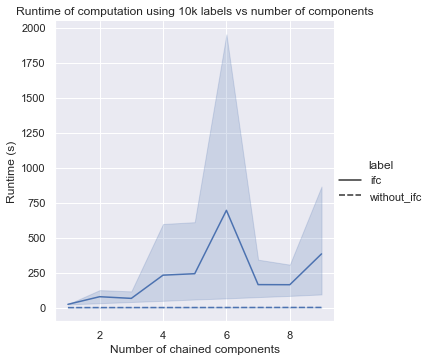

In [30]:
# Make plots


ifc_df = pd.concat([pd.DataFrame({"num_components": list(ifc_result.keys()), "time": list(ifc_result.values()), "label": "ifc", "idx": idx}) for idx, ifc_result in enumerate(ifc_results)])

without_ifc_df = pd.concat([pd.DataFrame({"num_components": list(without_ifc_result.keys()), "time": list(without_ifc_result.values()), "label": "without_ifc", "idx": idx}) for idx, without_ifc_result in enumerate(without_ifc_results)])

df = pd.concat([ifc_df, without_ifc_df]).reset_index()

sns.set(style="darkgrid")
sns.relplot(x="num_components", y="time", style="label", data=df, kind="line")
plt.title("Runtime of computation using 10k labels vs number of components")
plt.xlabel("Number of chained components")
plt.ylabel("Runtime (s)")
plt.show()

## Experiments to assess how pipeline runtime varies with number of labels deleted

In [37]:
# Add 100k labels. Delete from 1 to 100k labels.

deletion_times = []
preliminary_labels = [create_label() for _ in range(max_num_labels * 2)]

# Add labels to DB
create_labels(preliminary_labels)

ifc_results = []
without_ifc_results = []

for i in range(num_iter):
    ifc_result = {}
    without_ifc_result = {}
    deletion_time = {}

    for num_labels in range(1, max_num_labels, step_size):
        print(num_labels)
        inputs = np.random.rand(1000)
        labels = [create_label() for _ in range(step_size)]

        # Delete labels from DB
        random_subset = random.sample(preliminary_labels, num_labels)
        start_time = time.time()
        retract_labels(random_subset)  
        end_time = time.time()
        deletion_time[num_labels] = end_time - start_time

        # time the computation
        start_time = time.time()
        run_fake_computation_with_labels(inputs=inputs, labels=labels)
        end_time = time.time()

        # Log time
        ifc_result[num_labels] = end_time - start_time

        start_time = time.time()
        run_fake_computation_without_labels(inputs=inputs)
        end_time = time.time()
        without_ifc_result[num_labels] = end_time - start_time

    ifc_results.append(ifc_result)
    without_ifc_results.append(without_ifc_result)
    deletion_times.append(deletion_time)
    
    # Clean DB
    # clean_db()

1


KeyboardInterrupt: 

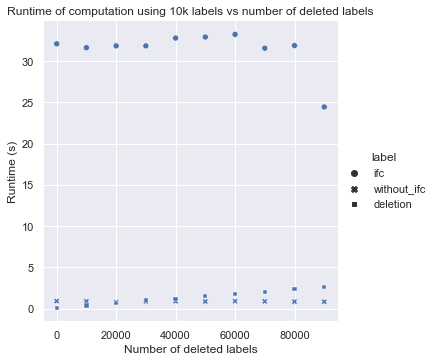

In [25]:
# Make plots

ifc_df = pd.DataFrame({"num_labels": list(ifc_results.keys()), "time": list(ifc_results.values()), "label": "ifc"})
without_ifc_df = pd.DataFrame({"num_labels": list(without_ifc_results.keys()), "time": list(without_ifc_results.values()), "label": "without_ifc"})
deletion_df = pd.DataFrame({"num_labels": list(deletion_times.keys()), "time": list(deletion_times.values()), "label": "deletion"})
df = pd.concat([ifc_df, without_ifc_df, deletion_df])

sns.set(style="darkgrid")
sns.relplot(x="num_labels", y="time", style="label", data=df)
plt.title("Runtime of computation using 10k labels vs number of deleted labels")
plt.xlabel("Number of deleted labels")
plt.ylabel("Runtime (s)")
plt.show()